In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Apr  4 10:02:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   45C    P0    34W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   34C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_30Mar21 import ACN_2i4_10L_4S_BN_NI as ModelA

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/awkward/__init__.py:23: DeprecationWarning: Consider switching from 'awkward' to 'awkward1', since the new interface will become the default later this year (2020).

    pip install -U awkward1

In Python:

    >>> import awkward1 as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  DeprecationWarning


Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 100, 1e-6, 100)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features

## This is used when training with the original KDE
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

'''
## This is used when training with the new KDE
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=args.batch_size,
                            device=device,
                            masking=True, shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=args.batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            ##slice = slice(18000,None)
                           )
'''

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 12.77 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 12.68 s
Loaded /share/lazy/will/ML_mdsA/June30_2020_80k_1.h5 in 12.31 s
Constructing 240000 event dataset took 6.688 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 3.074 s
Constructing 9984 event dataset took 0.09319 s


"\n## This is used when training with the new KDE\ntrain_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',\n                            '/share/lazy/will/data/June30_2020_80k_3.h5',\n                            batch_size=args.batch_size,\n                            device=device,\n                            masking=True, shuffle=True,\n                           ## slice = slice(0,18000)\n                           )\n\nval_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',\n                            batch_size=args.batch_size,\n                            device=device,\n                            masking=True, shuffle=True,\n                            ##slice = slice(18000,None)\n                           )\n"

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
# Set model to use (defined above)
model = ModelA()

# Prints out layout of each model (keep commented out)
##summary(model, input_size=(4, 4000))
##print(model.parameters)

# Sets save directory for mlflow
mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

# When loading pretrained models, use this code; otherwise, comment it out
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/88a7d95d1df3432599fb7b289a08d92e/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=True)

we also froze 0 weights
Of the 35.0 parameter layers to update in the current model, 31.5 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

ACN_2i4_10L_4S_BN_NI(
  (conv1): Conv(
    (0): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Conv(
    (0): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv3): Conv(
    (0): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv4): Conv(
    (0): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


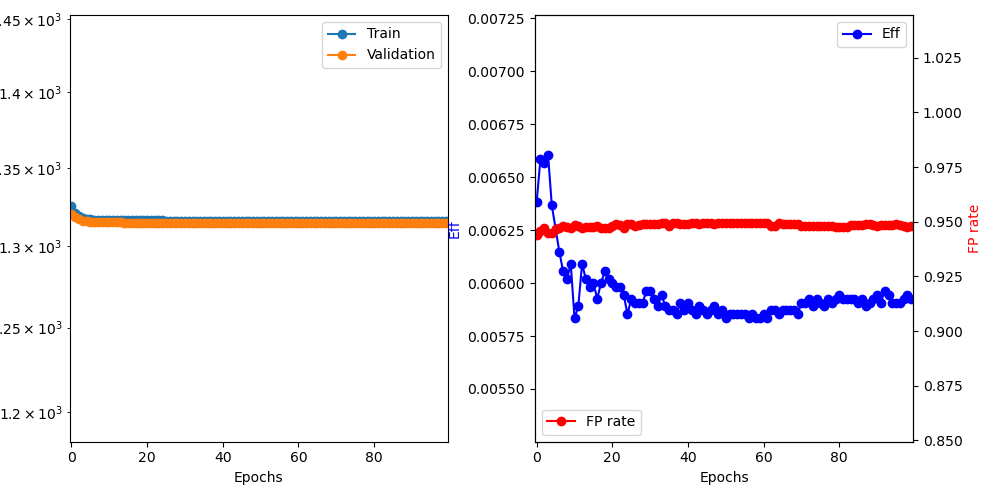

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  ACN_2i4_10L_4S_BN_NI(
  (conv1): Conv(
    (0): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Conv(
    (0): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv3): Conv(
    (0): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.15, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (conv4): Conv(
    (0): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): D

/home/michael24peters/pv-finder/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 100: train=1325.11, val=1320.51, took 78.905 s
  Validation Found 348 of 54504, added 9424 (eff 0.64%) (0.944 FP/event)


Epoch 101: train=1320.97, val=1318.44, took 78.534 s
  Validation Found 359 of 54504, added 9442 (eff 0.66%) (0.946 FP/event)


Epoch 102: train=1319.25, val=1316.95, took 78.987 s
  Validation Found 358 of 54504, added 9458 (eff 0.66%) (0.947 FP/event)


Epoch 103: train=1317.95, val=1315.94, took 78.555 s
  Validation Found 360 of 54504, added 9434 (eff 0.66%) (0.945 FP/event)


Epoch 104: train=1317.29, val=1315.6, took 79.746 s
  Validation Found 347 of 54504, added 9433 (eff 0.64%) (0.945 FP/event)


Epoch 105: train=1316.97, val=1315.42, took 78.591 s
  Validation Found 341 of 54504, added 9452 (eff 0.63%) (0.947 FP/event)


Epoch 106: train=1316.77, val=1315.33, took 78.77 s
  Validation Found 335 of 54504, added 9459 (eff 0.61%) (0.947 FP/event)


Epoch 107: train=1316.64, val=1315.18, took 78.447 s
  Validation Found 330 of 54504, added 9467 (eff 0.61%) (0.948 FP/event)


Epoch 108: train=1316.54, val=1315.08, took 78.271 s
  Validation Found 328 of 54504, added 9463 (eff 0.60%) (0.948 FP/event)


Epoch 109: train=1316.47, val=1315.09, took 78.882 s
  Validation Found 332 of 54504, added 9459 (eff 0.61%) (0.947 FP/event)


Epoch 110: train=1316.41, val=1315.01, took 78.203 s
  Validation Found 318 of 54504, added 9471 (eff 0.58%) (0.949 FP/event)


Epoch 111: train=1316.37, val=1314.97, took 78.194 s
  Validation Found 321 of 54504, added 9468 (eff 0.59%) (0.948 FP/event)


Epoch 112: train=1316.34, val=1314.95, took 78.174 s
  Validation Found 332 of 54504, added 9459 (eff 0.61%) (0.947 FP/event)


Epoch 113: train=1316.32, val=1314.94, took 78.583 s
  Validation Found 328 of 54504, added 9460 (eff 0.60%) (0.947 FP/event)


Epoch 114: train=1316.3, val=1314.92, took 78.168 s
  Validation Found 326 of 54504, added 9462 (eff 0.60%) (0.948 FP/event)


Epoch 115: train=1316.28, val=1314.92, took 78.621 s
  Validation Found 327 of 54504, added 9460 (eff 0.60%) (0.947 FP/event)


Epoch 116: train=1316.27, val=1314.9, took 78.188 s
  Validation Found 323 of 54504, added 9467 (eff 0.59%) (0.948 FP/event)


Epoch 117: train=1316.26, val=1314.88, took 79.438 s
  Validation Found 327 of 54504, added 9457 (eff 0.60%) (0.947 FP/event)


Epoch 118: train=1316.26, val=1314.89, took 78.278 s
  Validation Found 330 of 54504, added 9458 (eff 0.61%) (0.947 FP/event)


Epoch 119: train=1316.25, val=1314.89, took 79.307 s
  Validation Found 328 of 54504, added 9459 (eff 0.60%) (0.947 FP/event)


Epoch 120: train=1316.23, val=1314.88, took 78.317 s
  Validation Found 327 of 54504, added 9467 (eff 0.60%) (0.948 FP/event)


Epoch 121: train=1316.23, val=1314.88, took 78.81 s
  Validation Found 326 of 54504, added 9475 (eff 0.60%) (0.949 FP/event)


Epoch 122: train=1316.22, val=1314.87, took 78.705 s
  Validation Found 326 of 54504, added 9470 (eff 0.60%) (0.948 FP/event)


Epoch 123: train=1316.21, val=1314.86, took 78.204 s
  Validation Found 324 of 54504, added 9459 (eff 0.59%) (0.947 FP/event)


Epoch 124: train=1316.21, val=1314.86, took 78.224 s
  Validation Found 319 of 54504, added 9477 (eff 0.59%) (0.949 FP/event)


Epoch 125: train=1316.2, val=1314.85, took 78.832 s
  Validation Found 323 of 54504, added 9476 (eff 0.59%) (0.949 FP/event)


Epoch 126: train=1316.19, val=1314.85, took 78.497 s
  Validation Found 322 of 54504, added 9465 (eff 0.59%) (0.948 FP/event)


Epoch 127: train=1316.19, val=1314.84, took 79.041 s
  Validation Found 322 of 54504, added 9473 (eff 0.59%) (0.949 FP/event)


Epoch 128: train=1316.18, val=1314.84, took 80.335 s
  Validation Found 322 of 54504, added 9476 (eff 0.59%) (0.949 FP/event)


Epoch 129: train=1316.18, val=1314.83, took 80.382 s
  Validation Found 325 of 54504, added 9474 (eff 0.60%) (0.949 FP/event)


Epoch 130: train=1316.17, val=1314.83, took 80.467 s
  Validation Found 325 of 54504, added 9475 (eff 0.60%) (0.949 FP/event)


Epoch 131: train=1316.17, val=1314.82, took 80.551 s
  Validation Found 323 of 54504, added 9475 (eff 0.59%) (0.949 FP/event)


Epoch 132: train=1316.17, val=1314.82, took 80.548 s
  Validation Found 321 of 54504, added 9478 (eff 0.59%) (0.949 FP/event)


Epoch 133: train=1316.16, val=1314.81, took 80.294 s
  Validation Found 324 of 54504, added 9479 (eff 0.59%) (0.949 FP/event)


Epoch 134: train=1316.16, val=1314.81, took 80.512 s
  Validation Found 321 of 54504, added 9479 (eff 0.59%) (0.949 FP/event)


Epoch 135: train=1316.15, val=1314.81, took 80.579 s
  Validation Found 320 of 54504, added 9468 (eff 0.59%) (0.948 FP/event)


Epoch 136: train=1316.15, val=1314.8, took 80.353 s
  Validation Found 320 of 54504, added 9482 (eff 0.59%) (0.95 FP/event)


Epoch 137: train=1316.14, val=1314.81, took 80.409 s
  Validation Found 319 of 54504, added 9479 (eff 0.59%) (0.949 FP/event)


Epoch 138: train=1316.14, val=1314.79, took 78.745 s
  Validation Found 322 of 54504, added 9475 (eff 0.59%) (0.949 FP/event)


Epoch 139: train=1316.14, val=1314.8, took 78.288 s
  Validation Found 320 of 54504, added 9476 (eff 0.59%) (0.949 FP/event)


Epoch 140: train=1316.14, val=1314.8, took 78.112 s
  Validation Found 322 of 54504, added 9475 (eff 0.59%) (0.949 FP/event)


Epoch 141: train=1316.13, val=1314.79, took 78.502 s
  Validation Found 320 of 54504, added 9479 (eff 0.59%) (0.949 FP/event)


Epoch 142: train=1316.13, val=1314.79, took 78.155 s
  Validation Found 319 of 54504, added 9480 (eff 0.59%) (0.949 FP/event)


Epoch 143: train=1316.13, val=1314.8, took 78.198 s
  Validation Found 321 of 54504, added 9477 (eff 0.59%) (0.949 FP/event)


Epoch 144: train=1316.13, val=1314.8, took 78.488 s
  Validation Found 320 of 54504, added 9479 (eff 0.59%) (0.949 FP/event)


Epoch 145: train=1316.13, val=1314.79, took 78.874 s
  Validation Found 319 of 54504, added 9481 (eff 0.59%) (0.95 FP/event)


Epoch 146: train=1316.13, val=1314.79, took 79.124 s
  Validation Found 320 of 54504, added 9480 (eff 0.59%) (0.949 FP/event)


Epoch 147: train=1316.12, val=1314.8, took 79.083 s
  Validation Found 321 of 54504, added 9478 (eff 0.59%) (0.949 FP/event)


Epoch 148: train=1316.13, val=1314.79, took 78.236 s
  Validation Found 319 of 54504, added 9480 (eff 0.59%) (0.949 FP/event)


Epoch 149: train=1316.12, val=1314.79, took 81.26 s
  Validation Found 320 of 54504, added 9479 (eff 0.59%) (0.949 FP/event)


Epoch 150: train=1316.12, val=1314.79, took 82.208 s
  Validation Found 318 of 54504, added 9481 (eff 0.58%) (0.95 FP/event)


Epoch 151: train=1316.12, val=1314.79, took 80.516 s
  Validation Found 319 of 54504, added 9481 (eff 0.59%) (0.95 FP/event)


Epoch 152: train=1316.12, val=1314.79, took 82.567 s
  Validation Found 319 of 54504, added 9479 (eff 0.59%) (0.949 FP/event)


Epoch 153: train=1316.12, val=1314.79, took 80.891 s
  Validation Found 319 of 54504, added 9480 (eff 0.59%) (0.949 FP/event)


Epoch 154: train=1316.12, val=1314.8, took 80.439 s
  Validation Found 319 of 54504, added 9480 (eff 0.59%) (0.949 FP/event)


Epoch 155: train=1316.12, val=1314.8, took 79.817 s
  Validation Found 319 of 54504, added 9480 (eff 0.59%) (0.949 FP/event)


Epoch 156: train=1316.12, val=1314.79, took 82.472 s
  Validation Found 318 of 54504, added 9480 (eff 0.58%) (0.949 FP/event)


Epoch 157: train=1316.12, val=1314.79, took 80.014 s
  Validation Found 319 of 54504, added 9480 (eff 0.59%) (0.949 FP/event)


Epoch 158: train=1316.12, val=1314.79, took 78.114 s
  Validation Found 318 of 54504, added 9479 (eff 0.58%) (0.949 FP/event)


Epoch 159: train=1316.11, val=1314.79, took 78.414 s
  Validation Found 318 of 54504, added 9480 (eff 0.58%) (0.949 FP/event)


Epoch 160: train=1316.11, val=1314.78, took 78.326 s
  Validation Found 319 of 54504, added 9479 (eff 0.59%) (0.949 FP/event)


Epoch 161: train=1316.11, val=1314.78, took 78.705 s
  Validation Found 318 of 54504, added 9480 (eff 0.58%) (0.949 FP/event)


Epoch 162: train=1316.11, val=1314.79, took 78.984 s
  Validation Found 320 of 54504, added 9466 (eff 0.59%) (0.948 FP/event)


Epoch 163: train=1316.11, val=1314.78, took 78.304 s
  Validation Found 320 of 54504, added 9467 (eff 0.59%) (0.948 FP/event)


Epoch 164: train=1316.11, val=1314.77, took 78.221 s
  Validation Found 319 of 54504, added 9479 (eff 0.59%) (0.949 FP/event)


Epoch 165: train=1316.11, val=1314.77, took 78.186 s
  Validation Found 320 of 54504, added 9476 (eff 0.59%) (0.949 FP/event)


Epoch 166: train=1316.1, val=1314.76, took 78.345 s
  Validation Found 320 of 54504, added 9477 (eff 0.59%) (0.949 FP/event)


Epoch 167: train=1316.1, val=1314.78, took 78.176 s
  Validation Found 320 of 54504, added 9475 (eff 0.59%) (0.949 FP/event)


Epoch 168: train=1316.1, val=1314.76, took 78.156 s
  Validation Found 320 of 54504, added 9477 (eff 0.59%) (0.949 FP/event)


Epoch 169: train=1316.1, val=1314.76, took 78.157 s
  Validation Found 319 of 54504, added 9478 (eff 0.59%) (0.949 FP/event)


Epoch 170: train=1316.1, val=1314.77, took 79.07 s
  Validation Found 322 of 54504, added 9466 (eff 0.59%) (0.948 FP/event)


Epoch 171: train=1316.1, val=1314.76, took 78.518 s
  Validation Found 322 of 54504, added 9466 (eff 0.59%) (0.948 FP/event)


Epoch 172: train=1316.09, val=1314.75, took 78.352 s
  Validation Found 323 of 54504, added 9465 (eff 0.59%) (0.948 FP/event)


Epoch 173: train=1316.09, val=1314.76, took 78.581 s
  Validation Found 321 of 54504, added 9467 (eff 0.59%) (0.948 FP/event)


Epoch 174: train=1316.09, val=1314.75, took 80.289 s
  Validation Found 323 of 54504, added 9465 (eff 0.59%) (0.948 FP/event)


Epoch 175: train=1316.09, val=1314.74, took 78.212 s
  Validation Found 322 of 54504, added 9466 (eff 0.59%) (0.948 FP/event)


Epoch 176: train=1316.09, val=1314.75, took 78.202 s
  Validation Found 321 of 54504, added 9465 (eff 0.59%) (0.948 FP/event)


Epoch 177: train=1316.09, val=1314.75, took 78.265 s
  Validation Found 323 of 54504, added 9465 (eff 0.59%) (0.948 FP/event)


Epoch 178: train=1316.08, val=1314.74, took 78.692 s
  Validation Found 322 of 54504, added 9466 (eff 0.59%) (0.948 FP/event)


Epoch 179: train=1316.08, val=1314.75, took 79.046 s
  Validation Found 323 of 54504, added 9464 (eff 0.59%) (0.948 FP/event)


Epoch 180: train=1316.08, val=1314.74, took 79.13 s
  Validation Found 324 of 54504, added 9463 (eff 0.59%) (0.948 FP/event)


Epoch 181: train=1316.08, val=1314.73, took 79.059 s
  Validation Found 323 of 54504, added 9464 (eff 0.59%) (0.948 FP/event)


Epoch 182: train=1316.08, val=1314.74, took 78.288 s
  Validation Found 323 of 54504, added 9464 (eff 0.59%) (0.948 FP/event)


Epoch 183: train=1316.08, val=1314.74, took 79.14 s
  Validation Found 323 of 54504, added 9472 (eff 0.59%) (0.949 FP/event)


Epoch 184: train=1316.07, val=1314.74, took 79.14 s
  Validation Found 323 of 54504, added 9472 (eff 0.59%) (0.949 FP/event)


Epoch 185: train=1316.07, val=1314.73, took 78.639 s
  Validation Found 322 of 54504, added 9473 (eff 0.59%) (0.949 FP/event)


Epoch 186: train=1316.07, val=1314.73, took 78.608 s
  Validation Found 323 of 54504, added 9472 (eff 0.59%) (0.949 FP/event)


Epoch 187: train=1316.07, val=1314.73, took 78.599 s
  Validation Found 321 of 54504, added 9474 (eff 0.59%) (0.949 FP/event)


Epoch 188: train=1316.07, val=1314.73, took 78.607 s
  Validation Found 322 of 54504, added 9474 (eff 0.59%) (0.949 FP/event)


Epoch 189: train=1316.07, val=1314.72, took 78.598 s
  Validation Found 323 of 54504, added 9472 (eff 0.59%) (0.949 FP/event)


Epoch 190: train=1316.06, val=1314.72, took 78.594 s
  Validation Found 324 of 54504, added 9466 (eff 0.59%) (0.948 FP/event)


Epoch 191: train=1316.06, val=1314.73, took 78.588 s
  Validation Found 322 of 54504, added 9473 (eff 0.59%) (0.949 FP/event)


Epoch 192: train=1316.06, val=1314.71, took 78.604 s
  Validation Found 325 of 54504, added 9471 (eff 0.60%) (0.949 FP/event)


Epoch 193: train=1316.06, val=1314.72, took 78.599 s
  Validation Found 324 of 54504, added 9471 (eff 0.59%) (0.949 FP/event)


Epoch 194: train=1316.06, val=1314.72, took 78.876 s
  Validation Found 322 of 54504, added 9473 (eff 0.59%) (0.949 FP/event)


Epoch 195: train=1316.06, val=1314.71, took 79.846 s
  Validation Found 322 of 54504, added 9474 (eff 0.59%) (0.949 FP/event)


Epoch 196: train=1316.05, val=1314.72, took 79.065 s
  Validation Found 322 of 54504, added 9473 (eff 0.59%) (0.949 FP/event)


Epoch 197: train=1316.05, val=1314.71, took 79.101 s
  Validation Found 323 of 54504, added 9465 (eff 0.59%) (0.948 FP/event)


Epoch 198: train=1316.05, val=1314.71, took 79.328 s
  Validation Found 324 of 54504, added 9464 (eff 0.59%) (0.948 FP/event)


Epoch 199: train=1316.05, val=1314.72, took 79.103 s
  Validation Found 323 of 54504, added 9465 (eff 0.59%) (0.948 FP/event)
Averaging...

Average Eff:  0.005928005284015852
Average FP Rate:  0.9483725588382572



<IPython.core.display.Javascript object>


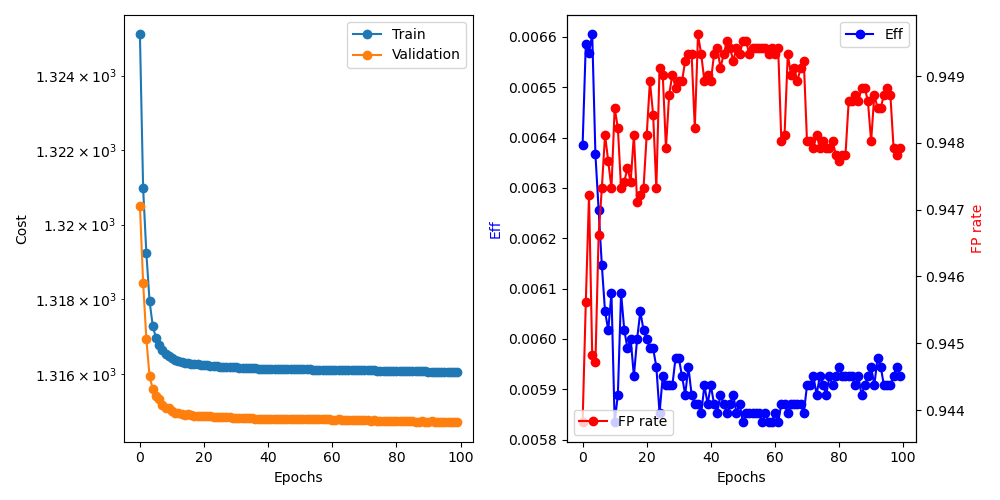

In [12]:
avgEff = 0.0
avgFP = 0.0

print('for model: ', model)   
run_name = 'ACN_2i4_10L_4S_BN_NI (P2)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))            
            
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        # If we are on the last 10 epochs but NOT the last epoch
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        # If we are on the last epoch
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            print('Average Eff: ', avgEff)
            print('Average FP Rate: ', avgFP)
            
        
        # Log tags
        mlflow.set_tag('Skip connections', '4')
        mlflow.set_tag('Asymmetry', '2.5')
        mlflow.set_tag('KDE_A', 'False')
        mlflow.set_tag('BN Input', 'True')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
    
    # Generate tight plot at end of training
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # Save plot
    plt.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

In [13]:
##quit()

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
